In [1]:
import pickle

experiment_path = 'results/empirical/empirical_MC_gamma1/'
network_data_path = experiment_path + 'network_data/'
performance_path = experiment_path + 'performance/'
module_mappings = pickle.load(open(network_data_path + 'module_mappings.pickle', 'rb'))
module_mappings_level2 = pickle.load(open(network_data_path + 'module_mappings_level2.pickle', 'rb'))

In [2]:
import numpy as np
from conn2res.connectivity import Conn

w = np.load('data/SC_wei_HCP_s400.npy')
conn = Conn(w=w)
#normalize the connectivity matrix to have a spectral radius of 1
conn.normalize()
w = 0.8*conn.w

In [3]:
import bct
from netneurotools.metrics import communicability_wei

strength = np.sum(w, axis=0)
mod_strength = {}
for module in np.unique(module_mappings):
    mod_strength[module] = np.mean(strength[module_mappings == module])

clustering = bct.clustering_coef_wu(w)
mod_clustering = {}
for module in np.unique(module_mappings):
    mod_clustering[module] = np.mean(clustering[module_mappings == module])

comm = communicability_wei(w)
#Add NaNs to diagonal
np.fill_diagonal(comm, np.nan)
communicability = np.nanmean(comm, axis=0)
mod_communicability = {}
for module in np.unique(module_mappings):
    mod_communicability[module] = np.mean(communicability[module_mappings == module])

In [4]:
#build an input-to-output module performance array
import os

NNETWORKS = 100
ALPHA = 0.8

nmodules = len(np.unique(module_mappings))
mod_perform = np.zeros((nmodules, nmodules, NNETWORKS))
for seed_file in os.listdir(performance_path):
    seed = int(seed_file.split('seed')[1].split('.npy')[0])
    seed_results = np.load(os.path.join(performance_path, seed_file), allow_pickle=True)
    for input_mod, MC in enumerate(seed_results['empirical']):
        for output_mod in np.unique(MC['module']):
            perform = MC[(MC['module'] == output_mod) & (MC['alpha'] == ALPHA)].score.values[0]
            mod_perform[input_mod, output_mod - 1, seed] = perform

#take out diagonal
mod_perform_no_diag = mod_perform.copy()
mod_perform_no_diag[np.arange(nmodules), np.arange(nmodules), :] = np.nan

In [5]:
#module means
#axes: 0 -> output module across inputs, 1 -> input module
in_out_perform_mat = np.nanmean(mod_perform_no_diag, axis=2)
input_perform = np.nanmean(in_out_perform_mat, axis=1)
output_perform = np.nanmean(in_out_perform_mat, axis=0)

/tmp/ipykernel_449149/1609360545.py:3: RuntimeWarning: Mean of empty slice
  in_out_perform_mat = np.nanmean(mod_perform_no_diag, axis=2)


In [6]:
#node-wise upsampling for plotting
node_wise_input_perform = []
node_wise_output_perform = []
node_wise_mod_strength = []
node_wise_mod_clustering = []
node_wise_mod_communicability = []
for mod in module_mappings:
    node_wise_input_perform.append(input_perform[mod - 1])
    node_wise_output_perform.append(output_perform[mod - 1])
    node_wise_mod_strength.append(mod_strength[mod])
    node_wise_mod_clustering.append(mod_clustering[mod])
    node_wise_mod_communicability.append(mod_communicability[mod])

np.save(experiment_path + 'node_wise_input_perform.npy', node_wise_input_perform)
np.save(experiment_path + 'node_wise_output_perform.npy', node_wise_output_perform)
np.save(network_data_path + 'node_wise_mod_strength.npy', node_wise_mod_strength)
np.save(network_data_path + 'node_wise_mod_clustering.npy', node_wise_mod_clustering)
np.save(network_data_path + 'node_wise_mod_communicability.npy', node_wise_mod_communicability)

In [7]:
from plot_point_brain import plot_point_brain
from score_plotting_utils import create_fig_path

fig_path = create_fig_path(experiment_path)

empirical_coords = np.load('data/s400_coords.npy')

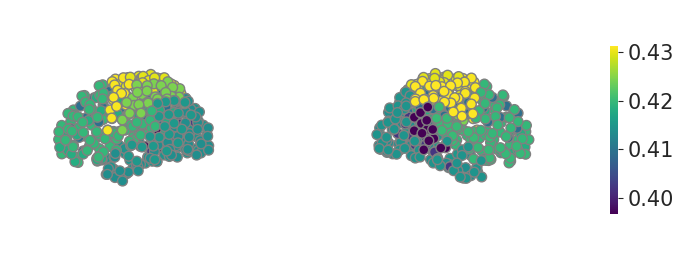

In [8]:
fig, ax = plot_point_brain(node_wise_input_perform, empirical_coords, views=['sag1', 'sag2'], views_orientation='horizontal', cmap='viridis', alpha=1, cbar=True)
fig.savefig(os.path.join(fig_path, 'point_brain_input_perform.svg'), dpi=300, bbox_inches='tight')

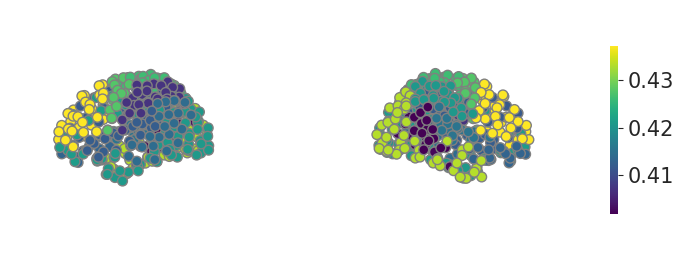

In [9]:
fig, ax = plot_point_brain(node_wise_output_perform, empirical_coords, views=['sag1', 'sag2'], views_orientation='horizontal', cmap='viridis', alpha=1, cbar=True)
fig.savefig(os.path.join(fig_path, 'point_brain_output_perform.svg'), dpi=300, bbox_inches='tight')

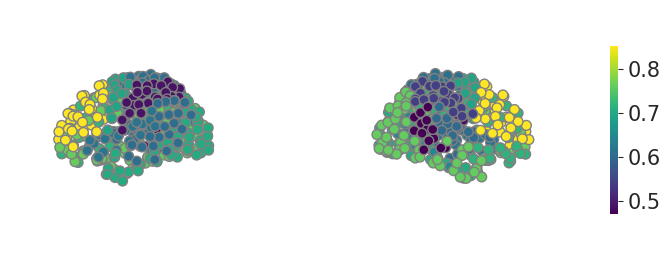

In [10]:
fig, ax = plot_point_brain(node_wise_mod_strength, empirical_coords, views=['sag1', 'sag2'], views_orientation='horizontal', cmap='viridis', alpha=1, cbar=True)
fig.savefig(os.path.join(fig_path, 'point_brain_strength.svg'), dpi=300, bbox_inches='tight')

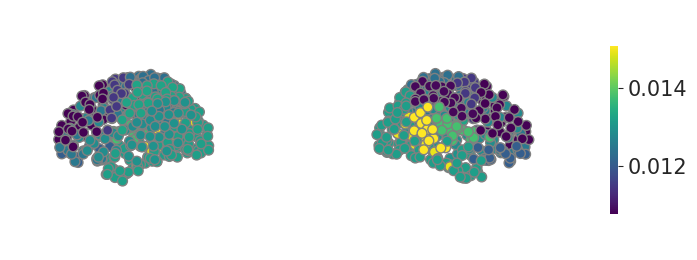

In [11]:
fig, ax = plot_point_brain(node_wise_mod_clustering, empirical_coords, views=['sag1', 'sag2'], views_orientation='horizontal', cmap='viridis', alpha=1, cbar=True)
fig.savefig(os.path.join(fig_path, 'point_brain_clustering.svg'), dpi=300, bbox_inches='tight')

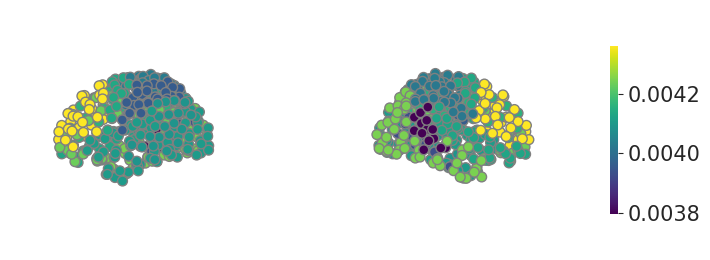

In [12]:
fig, ax = plot_point_brain(node_wise_mod_communicability, empirical_coords, views=['sag1', 'sag2'], views_orientation='horizontal', cmap='viridis', alpha=1, cbar=True)
fig.savefig(os.path.join(fig_path, 'point_brain_communicability.svg'), dpi=300, bbox_inches='tight')

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

sns.set_style("ticks")
sns.set(context=None, style=None, palette=None, font_scale=5, color_codes=None)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 15})
plt.rcParams['legend.fontsize'] = 15

PuRd = cm.get_cmap('PuRd')

from scipy.stats import spearmanr

perform_dict = {'input': input_perform, 'output': output_perform}
net_feats = {'strength': list(mod_strength.values()), 'clustering': list(mod_clustering.values()), 'communicability': list(mod_communicability.values())}
for io, perform in perform_dict.items():
    for net_feat, net_feat_vals in net_feats.items():
        corr = spearmanr(perform, net_feat_vals)
        print(f'{io} performance x {net_feat}: Spearman\'s rho = {corr.correlation:.3f}, p-value = {corr.pvalue:.3e}')

        ax = sns.regplot(x=net_feat_vals, y=perform, color=PuRd(0.6), seed=0)
        ax.set_box_aspect(1)

        ax.set_xlabel(f'mean node {net_feat}')
        ax.set_ylabel(f'{io} module MC')

        fig = ax.get_figure()
        fig.savefig(os.path.join(fig_path, f'{net_feat}_x_{io}_perform_corr.png'), dpi=300)
        fig.savefig(os.path.join(fig_path, f'{net_feat}_x_{io}_perform_corr.svg'), dpi=300)
        plt.close(fig)

input performance x strength: Spearman's rho = -0.200, p-value = 4.748e-01
input performance x clustering: Spearman's rho = -0.604, p-value = 1.720e-02
input performance x communicability: Spearman's rho = 0.068, p-value = 8.101e-01
output performance x strength: Spearman's rho = 0.557, p-value = 3.096e-02
output performance x clustering: Spearman's rho = -0.621, p-value = 1.340e-02
output performance x communicability: Spearman's rho = 0.675, p-value = 5.763e-03
